In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


In [8]:
data = pd.read_csv('../../data/obesity_final.csv')


# Categorical variables encoding

In [9]:
cat = [column for column in data.columns if data[column].dtype == 'object']
cat

['gender',
 'family_history_with_overweight',
 'favc',
 'caec',
 'smoke',
 'scc',
 'calc',
 'mtrans',
 'nobeyesdad']

In [10]:
for i in cat:
     print(f"{i}: {data[i].unique()}")

gender: ['Female' 'Male']
family_history_with_overweight: ['yes' 'no']
favc: ['no' 'yes']
caec: ['Sometimes' 'Frequently' 'Always' 'no']
smoke: ['no' 'yes']
scc: ['no' 'yes']
calc: ['no' 'Frequently' 'Sometimes' 'Always']
mtrans: ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
nobeyesdad: ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


## Ordinal encoding
For those categorical variables that have an intrinsic order 

In [11]:
from sklearn.preprocessing import OrdinalEncoder

# Crear una instancia de OrdinalEncoder
oe = OrdinalEncoder(categories=[
    ['no', 'Sometimes', 'Frequently', 'Always'],  # caec
    ['no', 'Frequently', 'Sometimes', 'Always'], # calc
    ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'] # nobeyesdad
])

# Encodear las variables categóricas con orden
data[['caec', 'calc', 'nobeyesdad']] = oe.fit_transform(data[['caec', 'calc', 'nobeyesdad']])



## Binary encoder

In [12]:
# Variables categóricas binarias
binary_categorical_vars = ['gender', 'family_history_with_overweight', 'favc', 'smoke', 'scc']

# Aplicar codificación binaria a las variables categóricas binarias
for binary in binary_categorical_vars:
    data[binary] = pd.get_dummies(data[binary], drop_first=True)

In [13]:
for i in ['gender',
 'family_history_with_overweight',
 'favc',
 'caec',
 'smoke',
 'scc',
 'calc',
 'mtrans',
 'nobeyesdad']:
     print(f"{i}: {data[i].unique()}")

gender: [False  True]
family_history_with_overweight: [ True False]
favc: [False  True]
caec: [1. 2. 3. 0.]
smoke: [False  True]
scc: [False  True]
calc: [0. 1. 2. 3.]
mtrans: ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
nobeyesdad: [1. 2. 3. 4. 0. 5. 6.]


## One hot encoding
For those categorical variables that have more than 2 categories and don't have any order

In [14]:
# Crear un DataFrame de ejemplo con la variable categórica mtrans
df = pd.DataFrame(data)

# Aplicar one-hot encoding con drop_first=True
encoded_df = pd.get_dummies(df['mtrans'], drop_first=True)

# Concatenar el DataFrame original con las nuevas variables dummy
df_encoded = pd.concat([df, encoded_df], axis=1)
data = df_encoded.drop('mtrans', axis=1)

# RF 

## Basic RF 
https://www.yourdatateacher.com/2021/10/11/feature-selection-with-random-forest/

In [15]:
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

In [16]:
X = data.drop(columns=['nobeyesdad'])
y = data['nobeyesdad']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [18]:
rf = RandomForestClassifier(random_state=0)

rf.fit(X_train,y_train)


RandomForestClassifier(random_state=0)

In [19]:
features = data.columns.tolist()

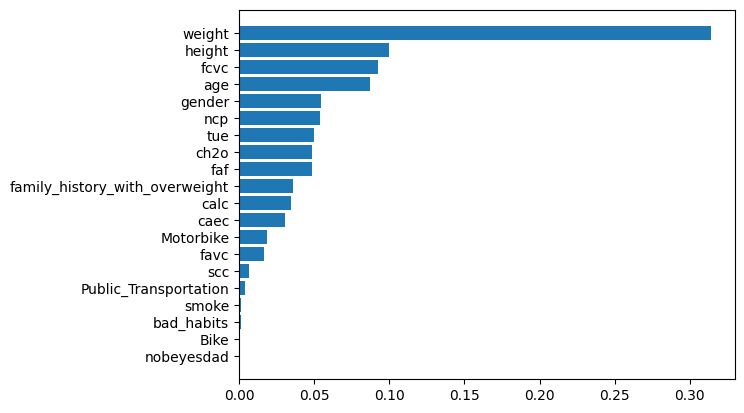

In [20]:
f_i = list(zip(features,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

## RF grid search

In [41]:
param_grid1 = {
    'n_estimators': [10,20],
    'criterion': ['entropy'],
    'max_depth': [None],
    'min_samples_split': [2,3,4],
    'max_features': ['sqrt'],
    'class_weight': ['balanced_subsample'],
    'n_jobs': [-1],
    'random_state':[42]
}

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid1)
grid.fit(X, y)
print("best mean cross-validation score =", grid.best_score_)
print(f"best parameters: {grid.best_params_}")
grid.best_estimator_
clf=grid.best_estimator_

best mean cross-validation score = 0.9298474468690495
best parameters: {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 20, 'n_jobs': -1, 'random_state': 42}


In [45]:
import time
import numpy as np
start_time = time.time()
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.028 seconds


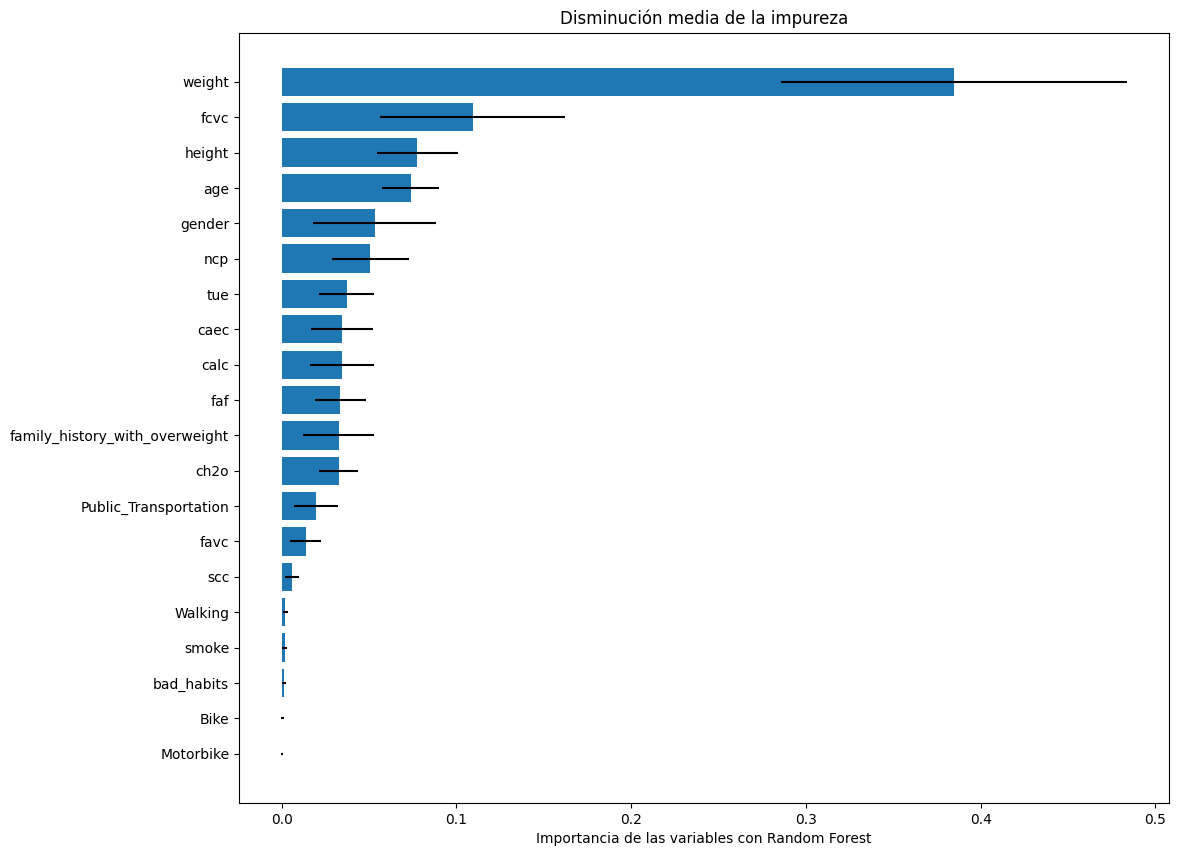

In [46]:
feature_names = X.columns
feature_names
#importances = forest.feature_importances_
#std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
sorted_idx = clf.feature_importances_.argsort()
ax, fig = plt.subplots(figsize=(12, 10))
plt.barh(feature_names[sorted_idx],clf.feature_importances_[sorted_idx],xerr= std[sorted_idx])
plt.xlabel('Importancia de las variables con Random Forest')
plt.title('Disminución media de la impureza')
plt.show()

In [47]:
datos_feature_ros= {'variables': feature_names[sorted_idx],'importancia':clf.feature_importances_[sorted_idx]}
dfdatos_feature_ros= pd.DataFrame(datos_feature_ros)
dfdatos_feature_ros.iloc[::-1]

,variables,importancia
19,weight,0.384753
18,fcvc,0.109232
17,height,0.077582
16,age,0.073835
15,gender,0.053207
14,ncp,0.050779
13,tue,0.037363
12,caec,0.034608
11,calc,0.034527
10,faf,0.033620


## RF Optuna
Optimization of hyperparammeters by using Optuna

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import optuna


In [80]:
import optuna
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Definir la función de objetivo para optimizar los hiperparámetros
def objective(trial):
    # Definir los hiperparámetros a optimizar
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # Construir el clasificador RandomForest con los hiperparámetros sugeridos
    rf_clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    
     # Validación cruzada con K-Fold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Entrenar el clasificador y calcular la precisión
        rf_clf.fit(X_train, y_train)
        y_pred = rf_clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)



    return sum(accuracies) / len(accuracies)

In [81]:
# Crear un estudio Optuna y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-04-10 14:35:33,975] A new study created in memory with name: no-name-fec1418f-5f1d-4b11-b024-37dce679ce7a
[I 2024-04-10 14:35:34,068] Trial 0 finished with value: 0.5252883626255772 and parameters: {'n_estimators': 13, 'max_depth': 2, 'min_samples_split': 0.17082076620716063, 'min_samples_leaf': 0.1586012907849187, 'max_features': 'log2'}. Best is trial 0 with value: 0.5252883626255772.
[I 2024-04-10 14:35:34,413] Trial 1 finished with value: 0.16432292236643392 and parameters: {'n_estimators': 72, 'max_depth': 2, 'min_samples_split': 0.26603858671075653, 'min_samples_leaf': 0.4994639102501982, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5252883626255772.
[I 2024-04-10 14:35:34,747] Trial 2 finished with value: 0.16432292236643392 and parameters: {'n_estimators': 70, 'max_depth': 3, 'min_samples_split': 0.39458923143202207, 'min_samples_leaf': 0.45370784996638247, 'max_features': 'log2'}. Best is trial 0 with value: 0.5252883626255772.
[I 2024-04-10 14:35:35,049] Tri

In [82]:
model =RandomForestClassifier(**study.best_params)
model.fit(X,y)

RandomForestClassifier(max_depth=17, min_samples_leaf=0.11017865271682117,
                       min_samples_split=0.25517612094131664, n_estimators=93)

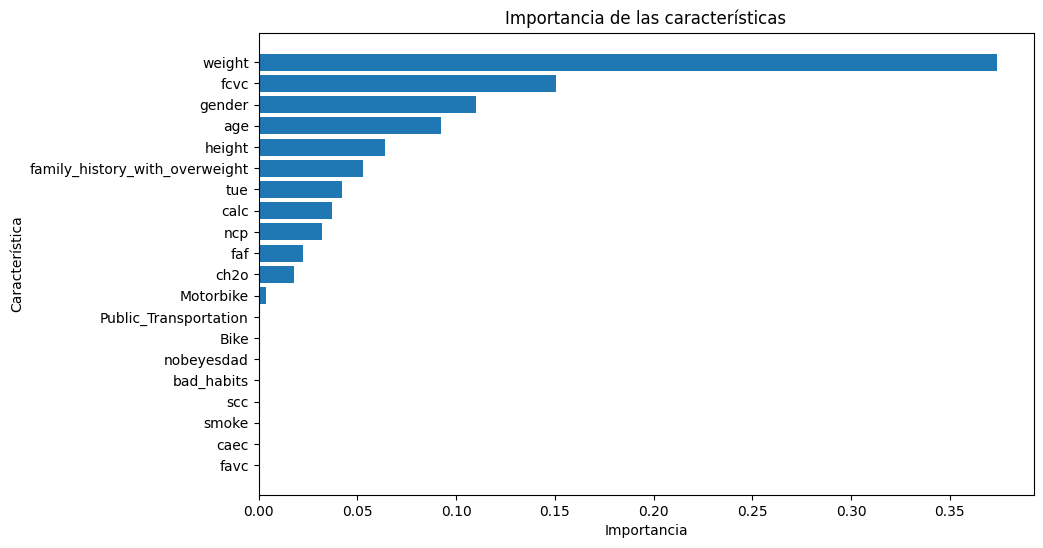

In [84]:
import matplotlib.pyplot as plt

# Obtener las características y sus importancias
feature_importances = list(zip(features, model.feature_importances_))

# Ordenar las características según su importancia
feature_importances.sort(key=lambda x: x[1])

# Crear un gráfico de barras horizontales de la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in feature_importances], [x[1] for x in feature_importances])
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de las características')
plt.show()

In [85]:
# Definir el umbral de importancia
threshold = 0.05  # Puedes ajustar este valor según tus necesidades

# Filtrar las características por encima del umbral
important_features = [feature[0] for feature in feature_importances if feature[1] > threshold]

# Imprimir las características seleccionadas
print("Características seleccionadas:", important_features)


Características seleccionadas: ['family_history_with_overweight', 'height', 'age', 'gender', 'fcvc', 'weight']
